In [1]:
# 1: Import + Database Connection
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
                              ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# เชื่อมต่อฐานข้อมูล MySQL (phpMyAdmin)
DB_USER = "root"
DB_PASSWORD = "" 
DB_HOST = "127.0.0.1"
DB_PORT = 3306
DB_NAME = "netflix"

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# อ่านข้อมูลทุกตารางที่ใช้
movie_df = pd.read_sql("SELECT * FROM movie;", engine)
view_df = pd.read_sql("SELECT * FROM view_summary;", engine)
tv_df = pd.read_sql("SELECT * FROM tv_show;", engine)
season_df = pd.read_sql("SELECT * FROM season;", engine)

print("movie:", movie_df.shape)
print("view_summary:", view_df.shape)
print("tv_show:", tv_df.shape)
print("season:", season_df.shape)
display(movie_df.head(), tv_df.head(), season_df.head())

movie: (11831, 9)
view_summary: (36746, 12)
tv_show: (4654, 8)
season: (8450, 9)


,id,created_date,modified_date,available_globally,locale,original_title,release_date,runtime,title
0,1,2024-01-01,2024-01-01,b'\x01',None,None,2024-03-08,110,Damsel
1,2,2024-01-01,2024-01-01,b'\x01',None,None,2024-01-12,107,Lift
2,3,2024-01-01,2024-01-01,b'\x01',None,La sociedad de la nieve,2024-01-04,146,Society of the Snow
3,4,2024-01-01,2024-01-01,b'\x01',None,Sous la Seine,2024-06-05,104,Under Paris
4,5,2024-01-01,2024-01-01,b'\x00',None,None,None,92,The Super Mario Bros. Movie


,id,created_date,modified_date,available_globally,locale,original_title,release_date,title
0,1,2024-01-01,2024-01-01,b'\x01',en,None,None,Fool Me Once
1,2,2024-01-01,2024-01-01,b'\x01',en,None,None,Bridgerton
2,3,2024-01-01,2024-01-01,b'\x01',en,None,None,Baby Reindeer
3,4,2024-01-01,2024-01-01,b'\x01',en,None,None,The Gentlemen
4,5,2024-01-01,2024-01-01,b'\x01',en,None,None,Avatar The Last Airbender


,id,created_date,modified_date,original_title,release_date,runtime,season_number,title,tv_show_id
0,1,2024-01-01,2024-01-01,None,2024-01-01,385,NaN,Fool Me Once: Limited Series,1
1,2,2024-01-01,2024-01-01,None,2024-05-16,479,3.0,Bridgerton: Season 3,2
2,3,2024-01-01,2024-01-01,None,2024-04-11,238,NaN,Baby Reindeer: Limited Series,3
3,4,2024-01-01,2024-01-01,None,2024-03-07,401,1.0,The Gentlemen: Season 1,4
4,5,2024-01-01,2024-01-01,None,2024-02-22,435,1.0,Avatar The Last Airbender: Season 1,5


In [2]:
# 2: Data Pre-Processing and Data Transformation

# รวม season -> tv_show
season_agg = season_df.groupby('tv_show_id', as_index=False).agg({
    'season_number':'max'
}).rename(columns={
    'season_number':'num_seasons'
})

# รวมกับ tv_show
tv_show_full = tv_df.merge(season_agg, left_on='id', right_on='tv_show_id', how='left')

# เลือกเฉพาะคอลัมน์ที่ไม่ซ้ำกับ movie_df ก่อน concat
tv_show_full_subset = tv_show_full.drop(columns=['created_date', 'modified_date', 'release_date', 'title'])

# สร้าง id ใหม่สำหรับ tv_show ให้ไม่ซ้ำกับ movie_df
max_movie_id = movie_df['id'].max()
tv_show_full_subset['id'] = tv_show_full_subset['id'] + max_movie_id + 1

# เพิ่ม flag
tv_show_full_subset['is_tvshow'] = 1
movie_df['is_tvshow'] = 0

# concat movie + tv_show
movie_all = pd.concat([movie_df, tv_show_full_subset], ignore_index=True, sort=False)

# รวมกับ view_summary
view_agg = view_df.groupby('movie_id', as_index=False)['hours_viewed'].sum()
df = movie_all.merge(view_agg, left_on='id', right_on='movie_id', how='inner')

# เติมค่า missing values

# runtime -> เติมด้วย median
if 'runtime' in df.columns:
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())

# num_seasons -> เติมด้วย 1
df['num_seasons'] = df['num_seasons'].fillna(1)

# available_globally -> เติมด้วย 0
df['available_globally'] = df['available_globally'].fillna(0)

# available_globally_flag -> 0/1
def to_bool_int(x):
    s = str(x).lower().strip()
    return 1 if s in ['1','true','yes','y','t'] else 0
df['available_globally_flag'] = df['available_globally'].apply(to_bool_int)

# original_title -> เติม 'unknown'
df['original_title'] = df['original_title'].fillna('unknown')

# release_date -> เติม '2000-01-01'
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_date'] = df['release_date'].fillna(pd.Timestamp('2000-01-01'))

# สร้าง release_year / month / day
df['release_year'] = df['release_date'].dt.year.astype(int)
df['release_month'] = df['release_date'].dt.month.astype(int)
df['release_day'] = df['release_date'].dt.day.astype(int)

# tv_show_id -> เติม 0
df['tv_show_id'] = df['tv_show_id'].fillna(0)

# locale -> แยก language / country
if 'locale' in df.columns:
    df['locale'] = df['locale'].fillna('unknown')
    df['language'] = df['locale'].apply(lambda x: str(x).split('-')[0].lower())
    df['country'] = df['locale'].apply(lambda x: str(x).split('-')[1].lower() if '-' in str(x) else 'unknown')
else:
    df['language'], df['country'] = 'unknown', 'unknown'

# กรองข้อมูลที่มีการรับชม
df = df[df['hours_viewed'] > 0]

# ตรวจสอบผลลัพธ์
print("After merging and filling missing:", df.shape)
display(df.head())

print("\nMissing values after filling:")
display(df.isna().sum())

print("\nDescriptive statistics:")
display(df.describe(include='all'))

After merging and filling missing: (11831, 20)


,id,created_date,modified_date,available_globally,locale,original_title,release_date,runtime,title,is_tvshow,tv_show_id,num_seasons,movie_id,hours_viewed,available_globally_flag,release_year,release_month,release_day,language,country
0,1,2024-01-01,2024-01-01,b'\x01',unknown,unknown,2024-03-08,110.0,Damsel,0,0.0,1.0,1.0,263700000,0,2024,3,8,unknown,unknown
1,2,2024-01-01,2024-01-01,b'\x01',unknown,unknown,2024-01-12,107.0,Lift,0,0.0,1.0,2.0,230800000,0,2024,1,12,unknown,unknown
2,3,2024-01-01,2024-01-01,b'\x01',unknown,La sociedad de la nieve,2024-01-04,146.0,Society of the Snow,0,0.0,1.0,3.0,252500000,0,2024,1,4,unknown,unknown
3,4,2024-01-01,2024-01-01,b'\x01',unknown,Sous la Seine,2024-06-05,104.0,Under Paris,0,0.0,1.0,4.0,146800000,0,2024,6,5,unknown,unknown
4,5,2024-01-01,2024-01-01,b'\x00',unknown,unknown,2000-01-01,92.0,The Super Mario Bros. Movie,0,0.0,1.0,5.0,191900000,0,2000,1,1,unknown,unknown



Missing values after filling:


id                         0
created_date               0
modified_date              0
available_globally         0
locale                     0
original_title             0
release_date               0
runtime                    0
title                      0
is_tvshow                  0
tv_show_id                 0
num_seasons                0
movie_id                   0
hours_viewed               0
available_globally_flag    0
release_year               0
release_month              0
release_day                0
language                   0
country                    0
dtype: int64


Descriptive statistics:


,id,created_date,modified_date,available_globally,locale,original_title,release_date,runtime,title,is_tvshow,tv_show_id,num_seasons,movie_id,hours_viewed,available_globally_flag,release_year,release_month,release_day,language,country
count,11831.000000,11831,11831,11831,11831,11831,11831,11831.000000,11831,11831.0,11831.0,11831.0,11831.000000,1.183100e+04,11831.0,11831.000000,11831.000000,11831.000000,11831,11831
unique,NaN,NaN,NaN,3,2,3957,NaN,NaN,11576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
top,NaN,NaN,NaN,b'\x00',unknown,unknown,NaN,NaN,Perfect Strangers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown
freq,NaN,NaN,NaN,9289,11276,7867,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11276,11831
mean,5916.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2003-03-05 04:41:02.277068672,105.543149,NaN,0.0,0.0,1.0,5916.000000,6.445541e+06,0.0,2003.094244,1.882766,3.203195,NaN,NaN
min,1.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2000-01-01 00:00:00,9.000000,NaN,0.0,0.0,1.0,1.000000,1.000000e+05,0.0,2000.000000,1.000000,1.000000,NaN,NaN
25%,2958.500000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2000-01-01 00:00:00,93.000000,NaN,0.0,0.0,1.0,2958.500000,2.000000e+05,0.0,2000.000000,1.000000,1.000000,NaN,NaN
50%,5916.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2000-01-01 00:00:00,103.000000,NaN,0.0,0.0,1.0,5916.000000,8.000000e+05,0.0,2000.000000,1.000000,1.000000,NaN,NaN
75%,8873.500000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2000-01-01 00:00:00,115.000000,NaN,0.0,0.0,1.0,8873.500000,4.200000e+06,0.0,2000.000000,1.000000,1.000000,NaN,NaN
max,11831.000000,2024-01-01 00:00:00,2024-01-01 00:00:00,NaN,NaN,NaN,2024-06-28 00:00:00,3892.000000,NaN,0.0,0.0,1.0,11831.000000,7.026000e+08,0.0,2024.000000,12.000000,31.000000,NaN,NaN


In [3]:
# 3: Feature Engineering
features = [
    'runtime', 'release_year', 'release_month', 'release_day',
    'available_globally_flag', 'language', 'country',
    'is_tvshow', 'num_seasons'
]
target = 'hours_viewed'

# สร้าง df_model สำหรับ train/test
df_model = df[features + [target]].copy()

train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

numeric_cols = [
    'runtime', 'release_year', 'release_month', 'release_day',
    'available_globally_flag', 'is_tvshow',
    'num_seasons'
]

# เติมค่าที่ขาด
for c in numeric_cols:
    train_df[c] = train_df[c].fillna(train_df[c].median())
    test_df[c] = test_df[c].fillna(train_df[c].median())

# จำกัดหมวดหมู่ยอดนิยม
def top_k_map(series, k=10):
    topk = series.value_counts().nlargest(k).index
    return series.apply(lambda x: x if x in topk else 'other')

train_df['language_top'] = top_k_map(train_df['language'])
train_df['country_top'] = top_k_map(train_df['country'])
test_df['language_top'] = test_df['language'].apply(lambda x: x if x in train_df['language_top'].unique() else 'other')
test_df['country_top'] = test_df['country'].apply(lambda x: x if x in train_df['country_top'].unique() else 'other')

# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(train_df[['language_top', 'country_top']])

# Cyclical features สำหรับ month/day
train_df['release_month_sin'] = np.sin(2 * np.pi * train_df['release_month']/12)
train_df['release_month_cos'] = np.cos(2 * np.pi * train_df['release_month']/12)
test_df['release_month_sin'] = np.sin(2 * np.pi * test_df['release_month']/12)
test_df['release_month_cos'] = np.cos(2 * np.pi * test_df['release_month']/12)

train_df['release_day_sin'] = np.sin(2 * np.pi * train_df['release_day']/31)
train_df['release_day_cos'] = np.cos(2 * np.pi * train_df['release_day']/31)
test_df['release_day_sin'] = np.sin(2 * np.pi * test_df['release_day']/31)
test_df['release_day_cos'] = np.cos(2 * np.pi * test_df['release_day']/31)

# Interaction feature
train_df['runtime_x_num_seasons'] = train_df['runtime'] * train_df['num_seasons']
test_df['runtime_x_num_seasons'] = test_df['runtime'] * test_df['num_seasons']

# Flag feature สำหรับภาษาอังกฤษ
train_df['is_english'] = (train_df['language_top'] == 'English').astype(int)
test_df['is_english'] = (test_df['language_top'] == 'English').astype(int)

# เพิ่ม feature ใหม่เข้า numeric_cols
numeric_cols += [
    'release_month_sin', 'release_month_cos',
    'release_day_sin', 'release_day_cos',
    'runtime_x_num_seasons',
    'is_english'
]

# --- ฟังก์ชันสร้าง X ---
def build_X(df_input):
    X_num = df_input[numeric_cols].values
    X_cat = ohe.transform(df_input[['language_top', 'country_top']])
    return np.hstack([X_num, X_cat])

X_train, X_test = build_X(train_df), build_X(test_df)
y_train, y_test = train_df[target].values, test_df[target].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9464, 16)
X_test shape: (2367, 16)
y_train shape: (9464,)
y_test shape: (2367,)


In [4]:
# 4: Model Evaluation

models_spec = []

# Linear / Regularized
models_spec += [
    ("Linear", LinearRegression(), {}),
    ("Ridge_0.1", Ridge(alpha=0.1, random_state=42), {}),
    ("Ridge_1", Ridge(alpha=1, random_state=42), {}),
    ("Ridge_10", Ridge(alpha=10, random_state=42), {}),
    ("Lasso_0.01", Lasso(alpha=0.01, random_state=42, max_iter=5000), {}),
    ("Lasso_0.1", Lasso(alpha=0.1, random_state=42, max_iter=5000), {}),
    ("Lasso_1", Lasso(alpha=1, random_state=42, max_iter=5000), {}),
    ("ElasticNet_0.01_0.2", ElasticNet(alpha=0.01, l1_ratio=0.2, random_state=42, max_iter=5000), {}),
    ("ElasticNet_0.01_0.5", ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=5000), {}),
    ("ElasticNet_0.1_0.5", ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000), {}),
]

# Decision Tree / Random Forest / ExtraTrees / Bagging
models_spec += [
    ("DT_depth5", DecisionTreeRegressor(max_depth=5, random_state=42), {}),
    ("DT_depth10", DecisionTreeRegressor(max_depth=10, random_state=42), {}),
    ("DT_depth15", DecisionTreeRegressor(max_depth=15, random_state=42), {}),
]

# Random Forest
for n_est in [50, 100, 150, 200, 250]:
    models_spec.append((f"RF_{n_est}", RandomForestRegressor(n_estimators=n_est, random_state=42, n_jobs=-1), {}))

# ExtraTrees
for n_est in [50, 100, 150]:
    models_spec.append((f"ET_{n_est}", ExtraTreesRegressor(n_estimators=n_est, random_state=42, n_jobs=-1), {}))

# Bagging Regressor
models_spec += [
    ("Bagging_DT5_20", BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=20, random_state=42), {}),
    ("Bagging_DT10_20", BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), n_estimators=20, random_state=42), {}),
]

# Gradient Boosting / AdaBoost / HistGradientBoosting
models_spec += [
    ("GBR_lr0.01_ne100", GradientBoostingRegressor(learning_rate=0.01, n_estimators=100, random_state=42), {}),
    ("GBR_lr0.1_ne100", GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=42), {}),
    ("GBR_lr0.01_ne200", GradientBoostingRegressor(learning_rate=0.01, n_estimators=200, random_state=42), {}),
    ("GBR_lr0.1_ne200", GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, random_state=42), {}),
    ("AdaBoost", AdaBoostRegressor(random_state=42), {}),
    ("HistGB", HistGradientBoostingRegressor(random_state=42), {}),
]

# KNN
models_spec += [
    ("KNN_3", KNeighborsRegressor(n_neighbors=3), {}),
    ("KNN_5", KNeighborsRegressor(n_neighbors=5), {}),
    ("KNN_7", KNeighborsRegressor(n_neighbors=7), {}),
]

# SVR
models_spec += [
    ("SVR_rbf_C0.1", SVR(kernel='rbf', C=0.1), {}),
    ("SVR_rbf_C1", SVR(kernel='rbf', C=1), {}),
    ("SVR_rbf_C10", SVR(kernel='rbf', C=10), {}),
    ("SVR_linear", SVR(kernel='linear', C=1), {}),
]

# MLP
models_spec += [
    ("MLP_50", MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42), {}),
    ("MLP_100_50", MLPRegressor(hidden_layer_sizes=(100,50), max_iter=700, random_state=42), {}),
    ("MLP_100_50_25", MLPRegressor(hidden_layer_sizes=(100,50,25), max_iter=800, random_state=42), {}),
]

# Train & Evaluate
results, trained_models = [], {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model, param in models_spec:
    print(f"Training {name} ...")
    
    # ถ้ามี parameter จะใช้ RandomizedSearchCV
    if param:
        rs = RandomizedSearchCV(model, param, n_iter=5, cv=cv,
                                scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        rs.fit(X_train, y_train)
        best_model = rs.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model

    # Prediction บน test set
    y_pred = best_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)

    # Cross-validation RMSE บน train set
    try:
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv,
                                    scoring='neg_mean_squared_error', n_jobs=-1)
        cv_rmse = np.mean(np.sqrt(-cv_scores))
    except Exception:
        cv_rmse = None

    # บันทึกผล
    results.append({
        "model": name,
        "cv_rmse_train": cv_rmse,
        "rmse_test": rmse_test,
        "r2_test": r2_test
    })
    trained_models[name] = best_model

# แปลงเป็น DataFrame
eval_df = pd.DataFrame(results)

# ฟังก์ชันสรุป top N models และจัด format ตัวเลข
def summarize_top_models(eval_df, top_n=10):
    df = eval_df.copy()
    df['cv_rmse_train'] = df['cv_rmse_train'].apply(lambda x: f"{x:,.0f}" if x is not None else "N/A")
    df['rmse_test'] = df['rmse_test'].apply(lambda x: f"{x:,.0f}")
    df['r2_test'] = df['r2_test'].apply(lambda x: f"{x:.3f}")
    df_sorted = df.sort_values('rmse_test').head(top_n)
    return df_sorted.reset_index(drop=True)

# แสดง top 10
top10_df = summarize_top_models(eval_df, top_n=10)
display(top10_df)

Training Linear ...
Training Ridge_0.1 ...
Training Ridge_1 ...
Training Ridge_10 ...
Training Lasso_0.01 ...
Training Lasso_0.1 ...
Training Lasso_1 ...
Training ElasticNet_0.01_0.2 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e+18, tolerance: 4.426e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+18, tolerance: 3.794e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Training ElasticNet_0.01_0.5 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e+18, tolerance: 3.794e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+18, tolerance: 3.643e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Training ElasticNet_0.1_0.5 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e+18, tolerance: 4.426e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+18, tolerance: 3.794e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Training DT_depth5 ...
Training DT_depth10 ...
Training DT_depth15 ...
Training RF_50 ...
Training RF_100 ...
Training RF_150 ...
Training RF_200 ...
Training RF_250 ...
Training ET_50 ...
Training ET_100 ...
Training ET_150 ...
Training Bagging_DT5_20 ...
Training Bagging_DT10_20 ...
Training GBR_lr0.01_ne100 ...
Training GBR_lr0.1_ne100 ...
Training GBR_lr0.01_ne200 ...
Training GBR_lr0.1_ne200 ...
Training AdaBoost ...
Training HistGB ...
Training KNN_3 ...
Training KNN_5 ...
Training KNN_7 ...
Training SVR_rbf_C0.1 ...
Training SVR_rbf_C1 ...
Training SVR_rbf_C10 ...
Training SVR_linear ...
Training MLP_50 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Training MLP_100_50 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Training MLP_100_50_25 ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

,model,cv_rmse_train,rmse_test,r2_test
0,Bagging_DT5_20,"18,730,268","16,196,415",0.479
1,GBR_lr0.1_ne100,"19,347,155","16,258,963",0.475
2,GBR_lr0.1_ne200,"19,443,644","16,330,799",0.470
3,GBR_lr0.01_ne200,"18,979,889","16,408,736",0.465
4,RF_250,"19,061,498","16,669,144",0.448
5,RF_100,"19,133,066","16,710,154",0.446
6,RF_200,"19,101,914","16,717,546",0.445
7,RF_150,"19,100,998","16,721,093",0.445
8,Bagging_DT10_20,"19,361,371","16,725,807",0.444
9,RF_50,"19,372,983","16,735,548",0.444


In [5]:
# 5: Model Fine-Tuning
# --- Fine-Tune RandomForest ---
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# ดึงโมเดลและพารามิเตอร์ที่ดีที่สุด
best_rf = grid.best_estimator_
best_params = grid.best_params_

# Prediction บน test set
y_pred_best = best_rf.predict(X_test)
rmse_after = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("Fine-Tuned RandomForestRegressor")
print("Best Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"Final RMSE on test set: {rmse_after:,.0f} hours")

# --- เปรียบเทียบกับ RMSE ก่อน Fine-Tune ---
rf_models_before = ['RF_50', 'RF_100', 'RF_150', 'RF_200', 'RF_250']

improvement_list = []

for model_name in rf_models_before:
    rmse_before = eval_df.loc[eval_df['model'] == model_name, 'rmse_test'].values[0]
    improvement_pct = ((rmse_before - rmse_after) / rmse_before) * 100
    improvement_list.append({
        'model': model_name,
        'rmse_before': rmse_before,
        'rmse_after': rmse_after,
        'improvement_%': improvement_pct
    })

# แปลงเป็น DataFrame และแสดงผล
improvement_df = pd.DataFrame(improvement_list)
improvement_df = improvement_df.sort_values('improvement_%', ascending=False).reset_index(drop=True)
display(improvement_df)

Fine-Tuned RandomForestRegressor
Best Parameters:
  max_depth: 5
  min_samples_split: 10
  n_estimators: 100
Final RMSE on test set: 16,081,034 hours


,model,rmse_before,rmse_after,improvement_%
0,RF_50,1.673555e+07,1.608103e+07,3.910917
1,RF_150,1.672109e+07,1.608103e+07,3.827853
2,RF_200,1.671755e+07,1.608103e+07,3.807450
3,RF_100,1.671015e+07,1.608103e+07,3.764894
4,RF_250,1.666914e+07,1.608103e+07,3.528136


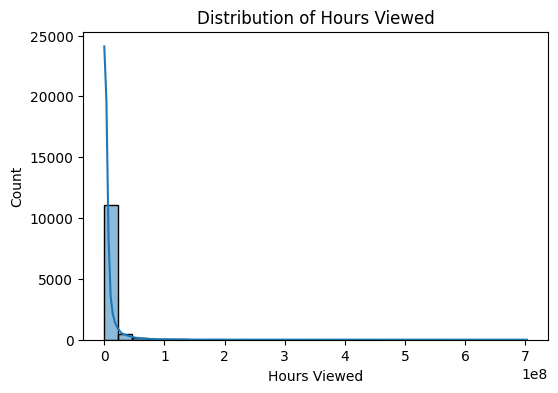

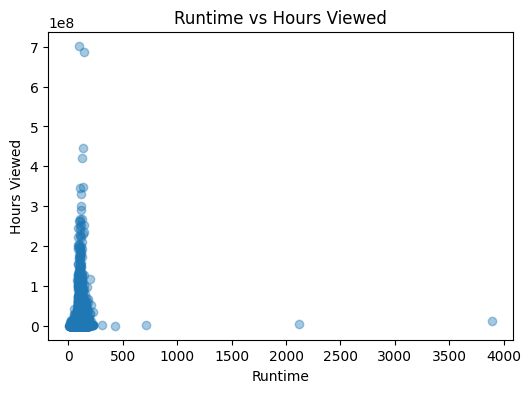

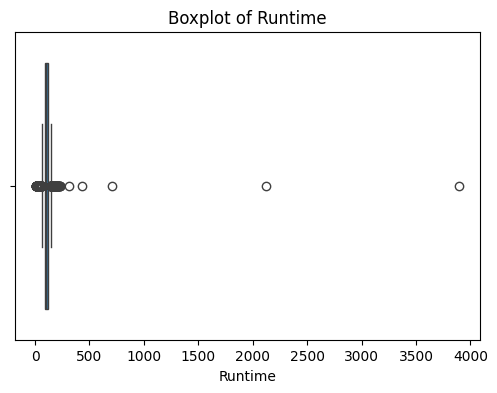

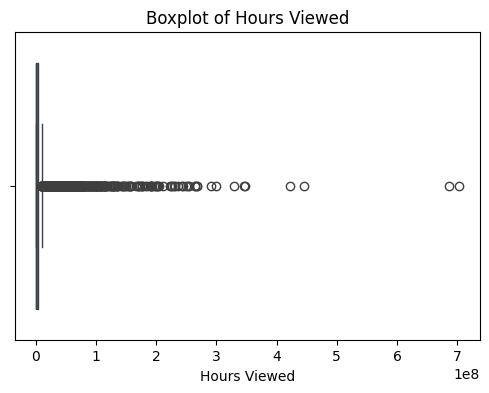

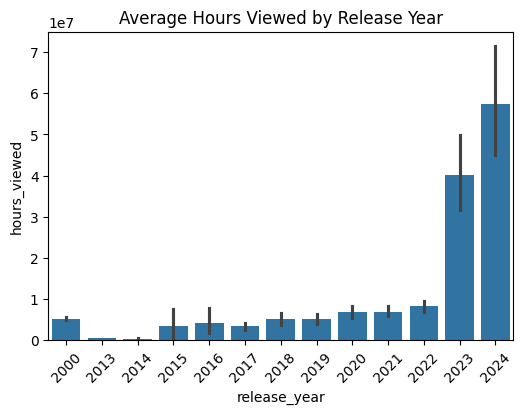

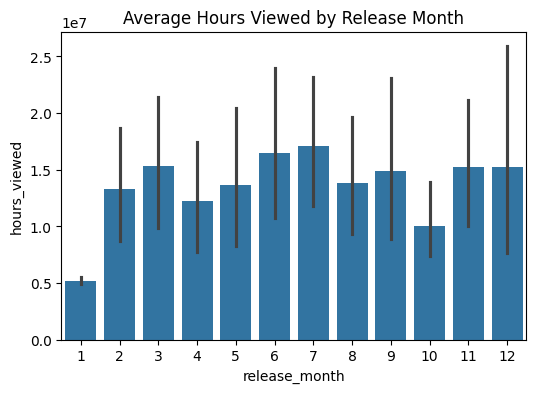

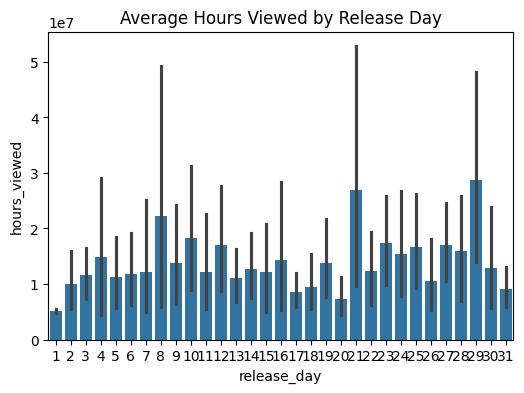

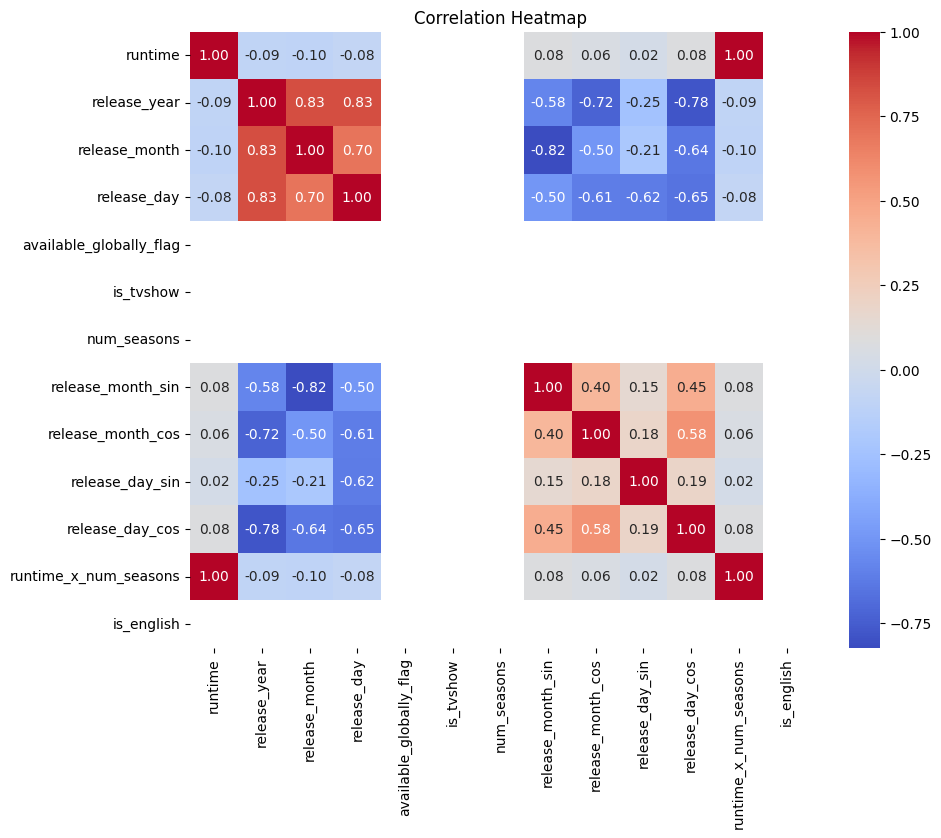

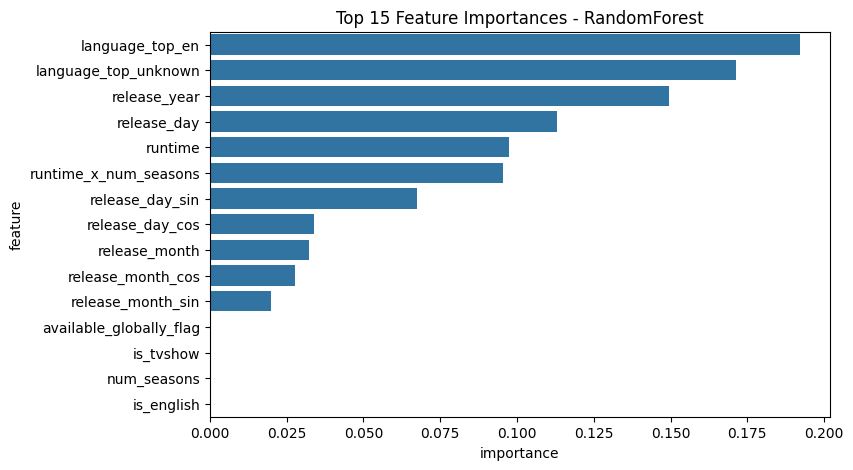

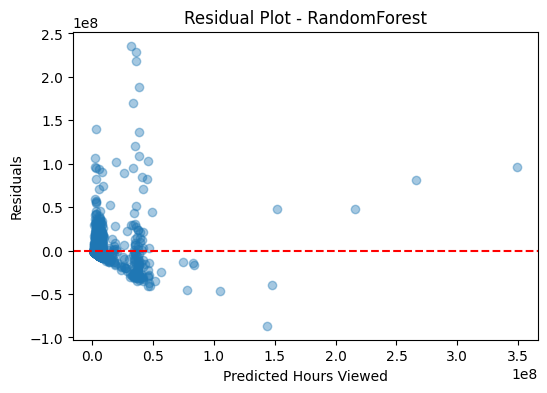

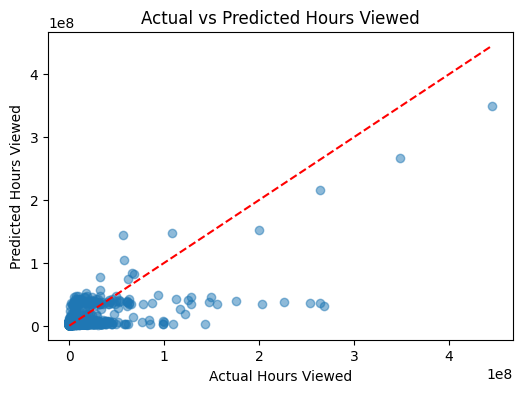

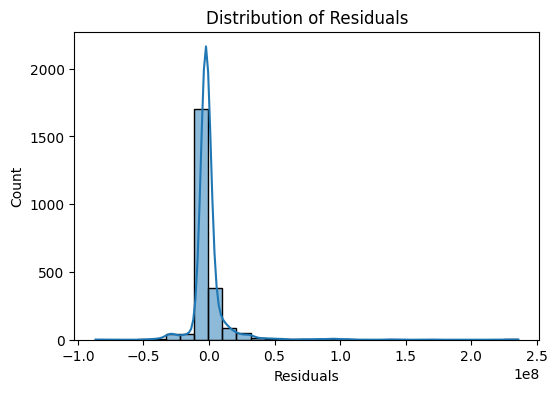

In [6]:
# 6: Visualization & Data Analytics

# 1. Distribution ของ hours_viewed 
plt.figure(figsize=(6,4))
sns.histplot(df_model['hours_viewed'], bins=30, kde=True)
plt.title("Distribution of Hours Viewed")
plt.xlabel("Hours Viewed")
plt.ylabel("Count")
plt.show()

# 2. Scatter plot runtime vs hours_viewed 
plt.figure(figsize=(6,4))
plt.scatter(df_model['runtime'], df_model['hours_viewed'], alpha=0.4)
plt.xlabel("Runtime")
plt.ylabel("Hours Viewed")
plt.title("Runtime vs Hours Viewed")
plt.show()

# 3. Boxplot ของ runtime
plt.figure(figsize=(6,4))
sns.boxplot(x=df_model['runtime'])
plt.title("Boxplot of Runtime")
plt.xlabel("Runtime")
plt.show()

# 4. Boxplot ของ hours_viewed
plt.figure(figsize=(6,4))
sns.boxplot(x=df_model['hours_viewed'])
plt.title("Boxplot of Hours Viewed")
plt.xlabel("Hours Viewed")
plt.show()

# 5. Average Hours Viewed by Release Year
plt.figure(figsize=(6,4))
sns.barplot(data=df_model, x='release_year', y='hours_viewed', estimator='mean')
plt.title("Average Hours Viewed by Release Year")
plt.xticks(rotation=45)
plt.show()

# 6. Average Hours Viewed by Release Month
plt.figure(figsize=(6,4))
sns.barplot(data=df_model, x='release_month', y='hours_viewed', estimator='mean')
plt.title("Average Hours Viewed by Release Month")
plt.show()

# 7. Average Hours Viewed by Release Day
plt.figure(figsize=(6,4))
sns.barplot(data=df_model, x='release_day', y='hours_viewed', estimator='mean')
plt.title("Average Hours Viewed by Release Day")
plt.show()

# 8. Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 9. Feature Importance using RandomForest
# สร้างโมเดล RandomForest และ train
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

feat_names = numeric_cols + list(ohe.get_feature_names_out(['language_top','country_top']))

feat_imp = pd.DataFrame({
    "feature": feat_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top 15 Feature Importances - RandomForest")
plt.show()

# 10. Residual Plot
y_pred = rf_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - RandomForest")
plt.xlabel("Predicted Hours Viewed")
plt.ylabel("Residuals")
plt.show()

# 11. Predicted vs Actual
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Hours Viewed")
plt.ylabel("Predicted Hours Viewed")
plt.title("Actual vs Predicted Hours Viewed")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# 12. Distribution of Residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.show()